## Imports 

In [7]:
import os
import sys
import json
import pickle
import joblib
import argparse
from tqdm import tqdm
from os import path
from git import Repo
from os.path import exists
from os import mkdir, remove, rename
import matplotlib.pyplot as plt
# from .autonotebook import tqdm as notebook_tqdm

import math
import random
import numpy as np
from sklearn.preprocessing import RobustScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.dataset import Dataset, random_split

torch.manual_seed(42)

# set up train device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: {}".format(device))

# setup project root dir
COLAB = 'google.colab' in sys.modules
if COLAB:
  root_dir = '/content'
  %mkdir ./data/
else:
  repo = Repo(".", search_parent_directories=True)
  root_dir = repo.git.rev_parse("--show-toplevel")
  sys.path.insert(0, root_dir+'/models/')
print("root: {}".format(root_dir))



device: cuda
root: /home/bitfra/Desktop/Francesco/rl_project/acrobatic-agents


# Import data

In [2]:
# Classic: Import data and build dataloader
experimental = False

availables_tasks = {
    0: 'backflip', 
    1: 'spinkick', 
    2: 'jump'
}

if not experimental: 

    task_type = availables_tasks[0] #insert here
    dataset_len = 5000
    tag=''
    import_dir = root_dir+'/data/'+ task_type + '/'
    raw_expert_observations = np.load(import_dir+'/expert-observations-'+str(dataset_len)+'.npy', allow_pickle=True)
    expert_actions = np.load(import_dir+'expert-actions-'+str(dataset_len)+'.npy', allow_pickle=True)

else:

    #Experimental: Run this cell to train on both tasks
    task_type = 'mixed'

    # Import for task 1
    dataset_len_1 = 20000
    task_1 = 'backflip'
    import_dir_1 = root_dir+'/data/'+ task_1 + '/'
    raw_expert_observations_bf = np.load(import_dir_1+'/expert-observations-'+str(dataset_len_1)+'.npy', allow_pickle=True)
    expert_actions_bf = np.load(import_dir_1+'expert-actions-'+str(dataset_len_1)+'.npy', allow_pickle=True)

    # import for task 2
    dataset_len_2 = 20000
    task_2 = 'spinkick'
    import_dir_2 = root_dir+'/data/'+ task_2 + '/'
    raw_expert_observations_sk = np.load(import_dir_2+'/expert-observations-'+str(dataset_len_2)+'.npy', allow_pickle=True)
    expert_actions_sk = np.load(import_dir_2+'expert-actions-'+str(dataset_len_2)+'.npy', allow_pickle=True)

    # import for task 3
    dataset_len_3 = 20000
    task_3 = 'jump'
    import_dir_3 = root_dir+'/data/'+ task_3 + '/'
    raw_expert_observations_jp = np.load(import_dir_3+'/expert-observations-'+str(dataset_len_3)+'.npy', allow_pickle=True)
    expert_actions_jp = np.load(import_dir_3+'expert-actions-'+str(dataset_len_3)+'.npy', allow_pickle=True)

    # decide task wheigt by trimming the datasets
    raw_expert_observations_bf = raw_expert_observations_bf[:5000]
    expert_actions_bf = expert_actions_bf[:5000]

    raw_expert_observations_sk = raw_expert_observations_sk[:]
    expert_actions_sk = expert_actions_sk[:]

    raw_expert_observations_jp = raw_expert_observations_jp[:0]
    expert_actions_jp = expert_actions_jp[:0]

    w1 = int(np.ceil(len(raw_expert_observations_bf) / (len(raw_expert_observations_bf) + 1)))
    w2 = int(np.ceil(len(raw_expert_observations_sk) / (len(raw_expert_observations_sk) + 1)))
    w3 = int(np.ceil(len(raw_expert_observations_jp) / (len(raw_expert_observations_jp) + 1)))
    tag = task_1[0]*w1 + task_2[4]*w2 + task_3[0]*w3

    dataset_len = len(raw_expert_observations_bf) + len(raw_expert_observations_sk) + len(raw_expert_observations_jp)

    # concatenate tasks
    raw_expert_observations = np.concatenate([raw_expert_observations_bf, raw_expert_observations_sk, raw_expert_observations_jp],axis=0)
    expert_actions = np.concatenate([expert_actions_bf, expert_actions_sk, expert_actions_jp],axis=0)

print('Task type: {}'.format(task_type))
print('Observations: {}'.format(raw_expert_observations.shape))
print('Actions: {}'.format(expert_actions.shape))

Task type: backflip
Observations: (5000, 197)
Actions: (5000, 36)


# Scaler

In [8]:
# Robust scaling

# Create a robust scaler object
scaler = RobustScaler()

# Fit the scaler to your data
scaler.fit(raw_expert_observations)
expert_observations = scaler.transform(raw_expert_observations)

# This will save the scaler to a file named 'scaler-xxxx.joblib'
# save_dir = root_dir+'/data/'+str(task_type)+'/'
# if not os.path.exists(save_dir):
#   os.makedirs(save_dir)
# joblib.dump(scaler, save_dir+'scaler-'+str(dataset_len)+'-'+str(tag)+'.joblib')  


# Data visualization

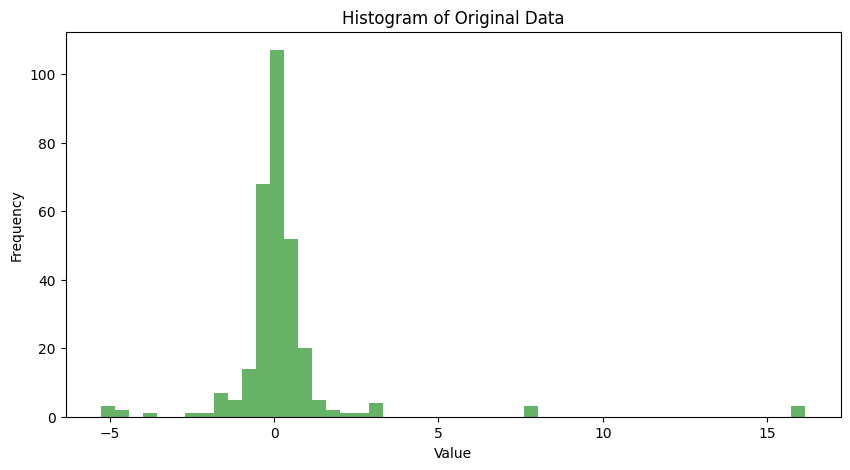

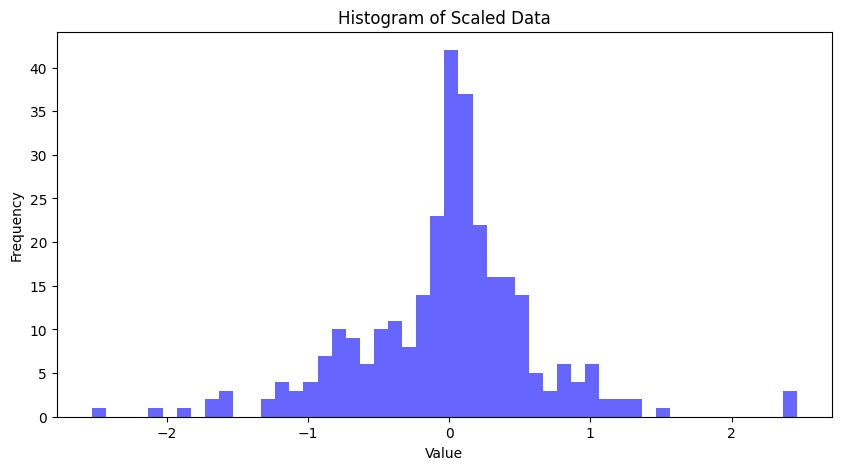

In [12]:
# Step 1: Concatenate your NumPy arrays
data = np.concatenate(raw_expert_observations)[:300]

# Step 2: Plot histograms before scaling
plt.figure(figsize=(10, 5))
plt.hist(data, bins=50, alpha=0.6, color='g')
plt.title('Histogram of Original Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# Step 3: Scale your data (done before)
data_scaled = np.concatenate(expert_observations)[:300]

# Step 4: Plot histograms after scaling
plt.figure(figsize=(10, 5))
plt.hist(data_scaled, bins=50, alpha=0.6, color='b')
plt.title('Histogram of Scaled Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

## Load Data

In [ ]:
# Dataset class

class ExpertDataSet(Dataset):

    def __init__(self, expert_observations, expert_actions):
        self.observations = torch.from_numpy(expert_observations).float()
        self.actions = self.__preprocess__(torch.from_numpy(expert_actions))
        

    def __getitem__(self, idx):
        # return (self.observations[index], self.actions[index])
        # normalized_observations = 2 * ((self.observations[idx] - self.observations.min()) / (self.observations.max() - self.observations.min())) - 1
        # normalized_data = (normalized_observations, self.actions[idx])
        # return normalized_data
        return self.observations[idx], self.actions[idx]


    def __len__(self):
        return len(self.observations)
    
    
    def __preprocess__(self, data, clip_value=1e38):
        # Clip values to a maximum and minimum range
        data = torch.clamp(data, min=-clip_value, max=clip_value)
        
        # Convert to float
        return data.float()
    
    def __min__max__(self):
        return self.observations.min(), self.observations.max() 

In [ ]:
# Make Datasets 

count_discarded_numpy = 0
count_discarded = 0

list_of_index_to_drop = []
for i, a in enumerate(expert_actions):
  if (a > 1e2).any() or (a > 1e2).any():
  # if not np.isfinite(a).all(): 
    list_of_index_to_drop.append(i)
    # print(i)
    # print(a)
    count_discarded_numpy+=1
    # break


print("Expert actions len: {}".format(len(expert_actions)))
print("Expert observations len: {}".format(len(expert_observations)))

expert_dataset = ExpertDataSet(expert_observations, expert_actions)

for i in range(len(expert_dataset)):
  a = expert_dataset.__getitem__(i)[1]
  # print(a.max())
  # print(a.min())
  if (a > 1e2).any() or (a < -1e2).any() :
  # if not torch.isfinite(a).any():
    count_discarded += 1
    # print(a)

print("Discarded form np: {}".format(count_discarded_numpy))
print("Discarded form torch: {}".format(count_discarded))

min_val, max_val = expert_dataset.__min__max__()

print("Observations min: {}".format(min_val))
print("Observations max: {}".format(max_val))


Expert actions len: 25000
Expert observations len: 25000
Discarded form np: 0
Discarded form torch: 0
Observations min: -21.900846481323242
Observations max: 19.29659652709961


In [ ]:
# Data Loaders

batch_size = 128
train_prop = 0.7
train_size = int(train_prop * len(expert_dataset))
test_size = int(0.2 * len(expert_dataset))
val_size = int(0.1 * len(expert_dataset))
train_expert_dataset, test_expert_dataset,val_expert_dataset = random_split(expert_dataset, [train_size, test_size,val_size])

train_loader = torch.utils.data.DataLoader(dataset=train_expert_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_expert_dataset, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader( dataset=val_expert_dataset, batch_size=batch_size, shuffle=False)

print("Actions shape: {}".format(train_loader.dataset.__getitem__(0)[1].shape))
print("Observations shape: {}".format(train_loader.dataset.__getitem__(0)[0].shape))


Actions shape: torch.Size([36])
Observations shape: torch.Size([197])


# BCO

## Models

In [ ]:
# Policy Agent FC
import bco_fc as bco

obs_space = train_loader.dataset.__getitem__(0)[0].shape[0]
action_space = train_loader.dataset.__getitem__(0)[1].shape[0]
policy = bco.BCOAgentFC(obs_space, action_space, h_size=obs_space*2).to(device)

print("Policy net: {}".format(policy))

Policy net: BCOAgentFC(
  (fc1): Linear(in_features=197, out_features=394, bias=True)
  (bn1): BatchNorm1d(394, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc2): Linear(in_features=394, out_features=36, bias=True)
)


In [ ]:
# Policy Agent CNN

import bco_cnn as bco_cnn
obs_space = train_loader.dataset.__getitem__(0)[0].shape[0]
action_space = train_loader.dataset.__getitem__(0)[1].shape[0]
policy = bco_cnn.BCOCNN(obs_space, action_space).to(device) # fix add hidden layer size

print("Policy net: {}".format(policy))

Policy net: BCOCNN(
  (conv1): Conv1d(1, 36, kernel_size=(5,), stride=(2,), padding=(1,))
  (conv2): Conv1d(36, 36, kernel_size=(3,), stride=(2,), padding=(2,))
  (fc1): Linear(in_features=1800, out_features=72, bias=True)
  (LRelu): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=72, out_features=36, bias=True)
)


## Training

In [ ]:
# Train functions

def train(
        policy,
        train_epochs,
        train_loader, 
        val_loader,
        optimizer,
        loss_criterion,
        scheduler,
        thrashold
    ):

    policy.train()
    loss = 0
    epoch_loss = 0
    unused_val = 0

    with tqdm(total=train_epochs, leave=True) as pbar:
        losses = np.empty(train_epochs)
        v_losses = np.empty(train_epochs)
        for epoch in range(train_epochs):
            for batch_idx, (data, target) in enumerate(train_loader):

                obs, expert_action = data.to(device), target.to(device)
                obs = obs.float()

                if policy.name == 'bco-cnn':
                    obs = obs.unsqueeze(1)
                

                optimizer.zero_grad()

                student_action = policy(obs)
                expert_action = expert_action.float()

                loss = loss_criterion(student_action, expert_action)
                # loss.register_hook(lambda grad: print(grad))
                loss.backward()
                # print("Loss: {}".format(loss.item()))

                if not loss.item() == torch.inf: 
                    epoch_loss += loss.item()
                    optimizer.step()
                    

                else:
                    unused_val += 1
                    print("### BATCH {} ###".format(batch_idx))
                    print(f'obs -> {obs}')
                    print("\n______________________________________________________________________________")
                    print(f'expert_action -> {expert_action}')
                    print("\n______________________________________________________________________________")
                    print(f'student_action -> {student_action}')
                    print("\n______________________________________________________________________________")
                    return expert_action,student_action

                res = print_gradients(policy)
                
                if torch.isnan(student_action).any(): 
                    print('e successo')
                    break

                if res == 1: 
                    print("\n______________________________________________________________________________")
                    print(student_action.shape)
                    for i, ea in enumerate(expert_action):
                        if not np.isfinite(ea).all():
                            print(i+64)
                            print(f'expert_action -> {ea}')

                    print("\n______________________________________________________________________________")
                    print(f'Max expert_action -> {expert_action.max()}')
                    print(f'Min expert_action -> {expert_action.min()}')
                    print(f'Max student_action -> {student_action.max()}')
                    print(f'Min student_action -> {student_action.min()}')
                    break
            
            t_loss = epoch_loss/(batch_idx+1)
            v_loss = validation(val_loader, policy, loss_criterion)
            epoch_loss = 0
            unused_val = 0
            v_losses[epoch]=v_loss
            losses[epoch]=t_loss
            pbar.set_postfix(train=t_loss, validation=v_loss)
            pbar.update(1)
            
        
        print("###############################################################################\n")
        print("Train Loss: {}".format(t_loss))
        print("Validation Loss: {}".format(v_loss))
        print("###############################################################################\n")

    np.save('t_losses.npy', np.array(losses, dtype=object), allow_pickle=True)
    np.save('v_losses.npy', np.array(v_losses, dtype=object), allow_pickle=True)

def validation(loader, policy,loss_criterion):
    policy.eval()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(loader):
        obs, expert_action = data.to(device), target.to(device)
        obs = obs.float()
        if policy.name == 'bco-cnn':
            obs = obs.unsqueeze(1)
        student_action = policy(obs)
        loss = loss_criterion(student_action, expert_action)
        epoch_loss += loss.item()

    return epoch_loss/(batch_idx+1)

def print_gradients(policy):
    for name, param in policy.named_parameters():
        if param.requires_grad:
            if torch.isnan(param.grad).any(): 
                return 1#break
            # print(f"Gradient of {name}: {param.grad}")
    return 0

# Train module

loss_criterion = nn.MSELoss()
# Create a learning rate scheduler
step_size = 80
gamma = 0.3
learning_rate = 1e-3
optimizer =  optim.Adam(policy.parameters(), lr=learning_rate)
optimizer =  optim.SGD(policy.parameters(), lr=learning_rate, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
eval_epochs = 5

print("Training env:")
print(policy)
print("Loss function: {}".format(loss_criterion))
print("Optimizer: {}".format(optimizer))
print("Batch size: {}".format(batch_size))

Training env:
BCOAgentFC(
  (fc1): Linear(in_features=197, out_features=394, bias=True)
  (bn1): BatchNorm1d(394, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (fc2): Linear(in_features=394, out_features=36, bias=True)
)
Loss function: MSELoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
Batch size: 128


In [ ]:
train(policy, 
      train_epochs=2000, 
      train_loader=train_loader, 
      val_loader=val_loader,
      optimizer=optimizer,
      loss_criterion=loss_criterion,
      scheduler=scheduler,
      thrashold = 100
    )

100%|██████████| 2000/2000 [06:24<00:00,  5.20it/s, train=0.00096, validation=0.00124] 

###############################################################################

Train Loss: 0.0009603833615691503
Validation Loss: 0.0012369466247037053
###############################################################################



## Load losses

In [ ]:
#Load losses
ta = np.load('t_losses.npy',allow_pickle=True)
tva = np.load('v_losses.npy',allow_pickle=True)

print(ta)

[0.3490727497060804 0.25288042154190316 0.24048466806429147 ...
 0.18900136203661452 0.1889384159424009 0.18888150470970322]


## Testing

In [ ]:
def test(policy, test_loader,loss_criterion):
    policy.eval()   
    loss = 0
    epoch_loss = 0
    
    for batch_idx, (data, target) in enumerate(test_loader):

        obs, expert_action = data.to(device), target.to(device)
        obs = obs.float()
        
        if policy.name == 'bco-cnn':
            obs = obs.unsqueeze(1)

        student_action = policy(obs)
        expert_action = expert_action.float()

        loss = loss_criterion(student_action, expert_action)

        if not loss.item() == torch.inf: 
            epoch_loss += loss.item()
        
        if torch.isnan(student_action).any(): 
            print('e successo')
            break
        
    t_loss = epoch_loss/(batch_idx+1)
    epoch_loss = 0
            
    
    print("Test Loss: {}".format(t_loss))

In [ ]:
test(policy=policy, test_loader=test_loader, loss_criterion=loss_criterion)

Test Loss: 0.001251277966366615


## Saving

In [ ]:
# Save model

 # saving
save_dir = root_dir+'/checkpoints/'+str(task_type)+'/'
if not os.path.exists(save_dir):
  os.makedirs(save_dir)

version = str(dataset_len)[:-3] + 'k-' + str(tag)
policy.save_parameters(save_dir, version)

# Path to the JSON file
file_path = root_dir + '/versions/model_versions.json'

model_type = policy.name + '-' + task_type
model_version = version

# Check if the file exists
if os.path.exists(file_path):

    # Read the existing data
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Update the data
    if model_type in data:
        if model_version not in data[model_type]:
            data[model_type].append(model_version)
    else:
        data[model_type] = [model_version]

else:
    # File doesn't exist, use update_data as the initial data
    data = {
        model_type: [model_version]
    }

# Write the updated data back to the file
with open(file_path, 'w') as file:
    json.dump(data, file, indent=4)

print("Lookup table updated")

Lookup table updated


## Loading 

In [ ]:
src = root_dir+'/checkpoints/'+policy.name.lower()+'.pt'
policy.load_parameters(src)
print(root_dir+'/checkpoints/'+policy.name.lower()+'.pt')

Loading model Behavioral-Cloning-Agent state parameters
From :/home/bitfra/Desktop/Francesco/rl_project/acrobatic-agents/checkpoints/behavioral-cloning-agent.pt
/home/bitfra/Desktop/Francesco/rl_project/acrobatic-agents/checkpoints/behavioral-cloning-agent.pt
